<a href="https://colab.research.google.com/github/PrithaSarkar/Dissertation/blob/main/Pull_request_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GPU Availability**

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Installing and importing necessary packages.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import sklearn

Mounting drive and loading the datafile. Change the location as applicable.

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Dissertation UofG 2022/new_pullreq.csv")

In [4]:
columns = df.columns.to_list()
print(columns)

['id', 'project_id', 'github_id', 'pull_request_id', 'ownername', 'reponame', 'merged_or_not', 'lifetime_minutes', 'mergetime_minutes', 'num_commits', 'src_churn', 'test_churn', 'files_added', 'files_deleted', 'files_modified', 'files_changed', 'src_files', 'doc_files', 'other_files', 'num_commit_comments', 'num_issue_comments', 'num_comments', 'num_participants', 'sloc', 'team_size', 'perc_external_contribs', 'commits_on_files_touched', 'test_lines_per_kloc', 'test_cases_per_kloc', 'asserts_per_kloc', 'watchers', 'prev_pullreqs', 'requester_succ_rate', 'followers', 'churn_addition', 'churn_deletion', 'pr_comment_num', 'comment_num', 'perc_neg_emotion', 'perc_pos_emotion', 'perc_neu_emotion', 'part_num_issue', 'part_num_commit', 'part_num_pr', 'part_num_code', 'comment_conflict', 'hash_tag', 'at_tag', 'test_inclusion', 'description_length', 'bug_fix', 'ci_exists', 'ci_latency', 'ci_build_num', 'ci_test_passed', 'ci_failed_perc', 'ci_first_build_status', 'ci_last_build_status', 'languag

The "merged_or_not" metric states whether a pull-request was accepted or not. Let us check, how many of the 3 million pull-request was accepted and how many were rejected.

In [5]:
accepted = 0
rejected = 0
for ind in df.index:
  if df["merged_or_not"][ind]==1:
    accepted = accepted+1
  else:
    rejected = rejected+1

print("Accepted:", accepted)
print("Percentage:", (accepted/len(df))*100)
print("Rejected:", rejected)
print("Percentage:", (rejected/len(df))*100)

Accepted: 2710096
Percentage: 80.94823767591804
Rejected: 637841
Percentage: 19.051762324081963


There is a huge imbalance in the two classes. This needs to be kept in mind from this point onwards.

**Preparing data for small-scale experiment.**

The original dataset has 120 columns/metrics related to each pull-request. However, we will only focus on the metrics present in Table 1 of [this paper](https://dl.acm.org/doi/10.1145/3379597.3387489).

In [18]:
def flow_from_df(dataframe: pd.DataFrame, chunk_size: int = int(len(df)/2)):
  for start_row in range(0, dataframe.shape[0], chunk_size):
    end_row  = min(start_row + chunk_size, dataframe.shape[0])
    yield dataframe.iloc[start_row:end_row, :]

In [19]:
get_chunk = flow_from_df(df)
train_test = next(get_chunk)
train_test

,id,project_id,github_id,pull_request_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,...,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
0,1,13708387,1895,16946031,stylelint,stylelint,1,237,237.0,1,...,0,0,0,0,30.0,1,0.007948,0,237,0
1,2,100297899,353,51228565,Joaogarciadelima,checklistos,0,1410,NaN,1,...,0,2,0,0,597.0,0,0.830769,0,1410,0
2,3,93139005,404,42975776,binary-com,SmartCharts,1,4,4.0,1,...,0,0,0,0,2.0,0,0.314368,0,4,0
3,4,15059440,3434,34700062,letsencrypt,boulder,1,52,52.0,1,...,0,0,0,0,1.0,0,0.117332,0,52,0
4,5,29684214,486,34175163,PyCQA,astroid,1,2414,2414.0,1,...,0,0,0,0,2.0,0,0.010753,0,2414,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673963,1673964,8504763,1205,20816393,os-autoinst,openQA,1,77,77.0,1,...,1,2,0,0,6.0,1,0.119597,0,77,0
1673964,1673965,10789805,141,4184228,geopandas,geopandas,1,418,418.0,4,...,1,2,0,0,48.0,0,0.037736,0,418,0
1673965,1673966,26051663,5794,45711167,JMRI,JMRI,1,151,151.0,1,...,0,0,0,0,51.0,0,0.094772,0,151,0
1673966,1673967,4952323,91,2361445,spring-projects,spring-data-mongodb,0,122689,NaN,3,...,0,0,0,0,149.0,0,0.478788,0,122689,0


In [20]:
list_of_metrics = ['id','acc_commit_num', 'first_pr', 'core_member',
                  'contrib_gender', 'same_country', 'same_affiliation',
                  'social_strength', 'account_creation_days',
                  'first_response_time', 'contrib_country',
                  'prior_interaction', 'contrib_affiliation', 'perc_external_contribs',
                  'contrib_first_emo', 'contrib_follow_integrator',
                  'language', 'project_age', 'pushed_delta',
                  'pr_succ_rate', 'open_issue_num', 'open_pr_num', 'fork_num',
                  'churn_addition', 'bug_fix', 'test_inclusion',
                  'hash_tag', 'at_tag', 'part_num_issue', 'part_num_commit',
                  'part_num_pr', 'part_num_code','ci_exists', 'ci_latency',
                  'ci_test_passed', 'ci_failed_perc', 'churn_deletion',
                  'description_length', 'comment_conflict', 'pr_comment_num',
                  'part_num_code', 'ci_build_num', 'perc_inte_neg_emo', 'perc_inte_pos_emo',
                  'perc_inte_neu_emo','ci_first_build_status', 'ci_last_build_status',
                   'merged_or_not']

for metric in columns:
  if metric not in list_of_metrics:
    train_test.drop(metric, axis=1, inplace=True)

train_test

,id,merged_or_not,perc_external_contribs,churn_addition,churn_deletion,pr_comment_num,part_num_issue,part_num_commit,part_num_pr,part_num_code,...,contrib_affiliation,contrib_first_emo,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation
0,1,1,0.089869,0,0,0,1,0,0,0,...,NaN,NaN,0.000000,0.0,1.000000,0,28,0.000000,NaN,NaN
1,2,0,0.014019,0,0,0,1,0,0,0,...,NaN,NaN,0.000000,0.0,0.000000,0,300,0.250000,NaN,NaN
2,3,1,0.256849,0,0,0,0,0,0,0,...,NaN,NaN,0.000000,0.0,0.000000,0,505,0.428571,1.0,NaN
3,4,1,0.014706,110,3,0,0,0,0,0,...,NaN,NaN,0.000000,0.0,0.000000,1,460,0.138889,NaN,NaN
4,5,1,0.173077,60,0,0,1,0,0,0,...,NaN,NaN,0.000000,1.0,0.000000,1,6,0.125000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673963,1673964,1,0.011392,4,0,0,3,0,0,0,...,suse,neutral,0.000000,1.0,0.000000,0,132,0.384615,NaN,1.0
1673964,1673965,1,0.018182,173,2,0,4,0,0,0,...,mapbox,neutral,0.333333,0.0,0.666667,0,36,0.400000,1.0,0.0
1673965,1673966,1,0.254067,1,0,0,0,0,0,0,...,acm,NaN,0.000000,0.0,0.000000,0,204,0.215686,1.0,1.0
1673966,1673967,0,0.150327,15,14,0,0,0,0,0,...,NaN,NaN,0.000000,0.0,0.000000,1,88,0.285714,NaN,NaN


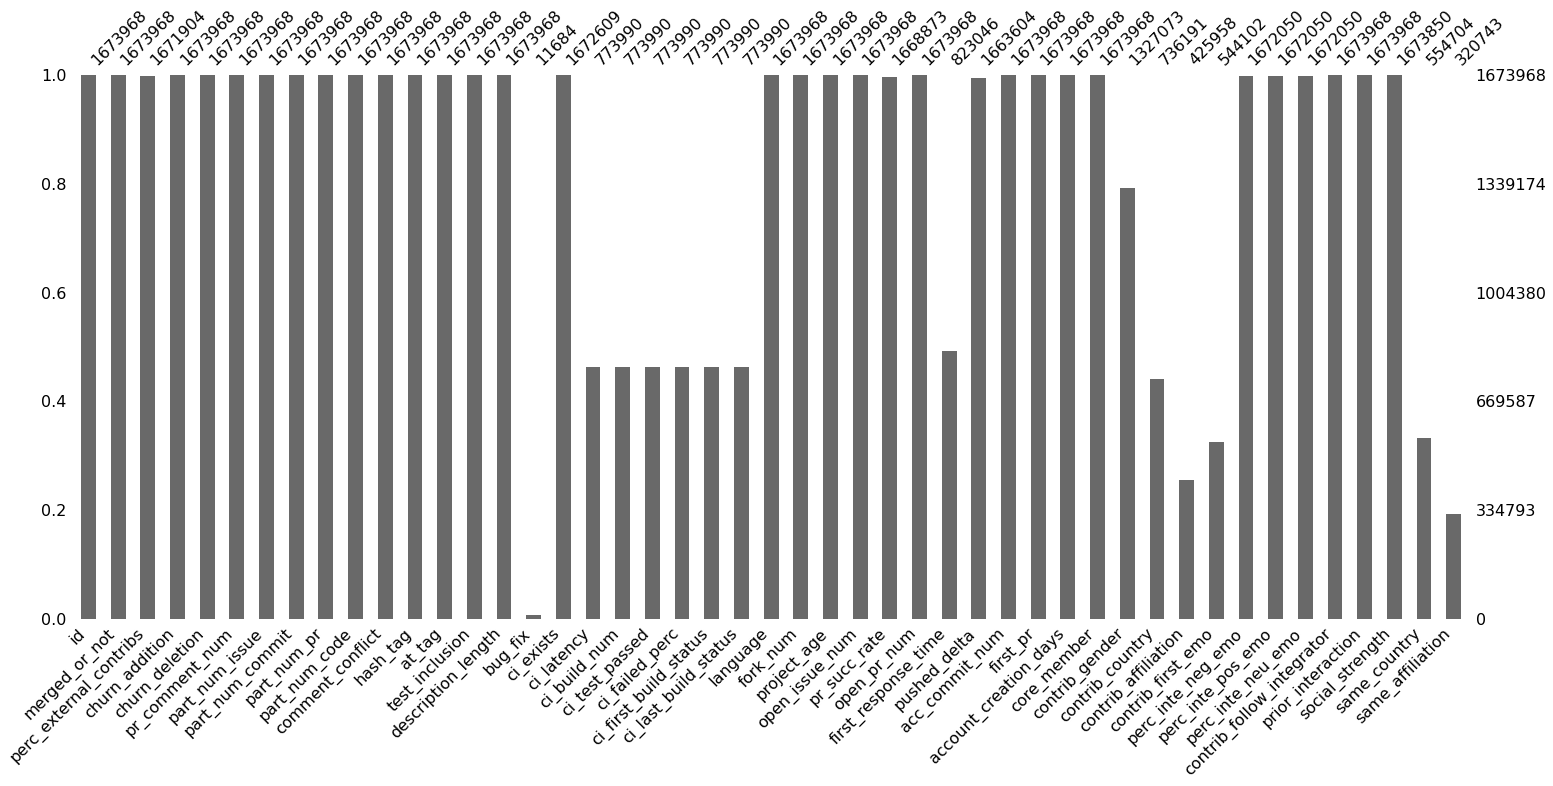

In [21]:
msno.bar(train_test)

Even though there are a couple of metrics which have high number of null values, decision to keep them for now has been taken. Feature selection will be done when XGBoost will be deployed on the data. Subsequently, the most important features will be observed and the rest of them will be dropped from the experiment.

Let us now see the percentage of accepted and rejected pull-request in this data chunk and see if the class imbalance remains the same or has worsened.

In [22]:
accepted = 0
rejected = 0
for ind in train_test.index:
  if train_test["merged_or_not"][ind]==1:
    accepted = accepted+1
  else:
    rejected = rejected+1

print("Accepted:", accepted)
print("Percentage:", (accepted/len(train_test))*100)
print("Rejected:", rejected)
print("Percentage:", (rejected/len(train_test))*100)

Accepted: 1355422
Percentage: 80.97060397809277
Rejected: 318546
Percentage: 19.029396021907232


Splitting the train_eval_test dataframe into separate training, evaluation and testing sets. 50% of the entire dataset will be used for training, 30% of the dataset will be used for evaluation/validation purposes and the remaining 20% will be used to run tests.

An important step before that would be to check the data types of every column since classification models would expect int, bool or float daat types. However, the dataset is diverse and annotation is required.

In [23]:
print(train_test.dtypes)

id                             int64
merged_or_not                  int64
perc_external_contribs       float64
churn_addition                 int64
churn_deletion                 int64
pr_comment_num                 int64
part_num_issue                 int64
part_num_commit                int64
part_num_pr                    int64
part_num_code                  int64
comment_conflict               int64
hash_tag                       int64
at_tag                         int64
test_inclusion                 int64
description_length             int64
bug_fix                      float64
ci_exists                    float64
ci_latency                   float64
ci_build_num                 float64
ci_test_passed               float64
ci_failed_perc               float64
ci_first_build_status         object
ci_last_build_status          object
language                      object
fork_num                       int64
project_age                    int64
open_issue_num                 int64
p

Metrics "ci_first_build_status", "ci_last_build_status", "language", "contrib_gender", contrib_country", "contrib_affiliation", "contrib_first_emo" have data type of object. This would cause trouble when deploying XGBoost. Annotation is needed in this case; manual or otherwise. Let's check the unique values present in each of these metrics.

In [24]:
object_metrics = ['ci_first_build_status', 'ci_last_build_status', 'language', 
                  'contrib_gender', 'contrib_country', 'contrib_affiliation', 'contrib_first_emo']

for metric in object_metrics:
  if metric == 'ci_first_build_status':
    ci_first_build_unique = train_test[metric].unique()
    print(metric,':', ci_first_build_unique, ', #',len(ci_first_build_unique))
  if metric == 'ci_last_build_status':
    ci_last_build_unique = train_test[metric].unique()
    print(metric,':', ci_last_build_unique, ', #',len(ci_last_build_unique))
  if metric == 'language':
    language_unique = train_test[metric].unique()
    print(metric,':', language_unique, ', #',len(language_unique))
  if metric == 'contrib_gender':
    cotrib_gender_unique = train_test[metric].unique()
    print(metric,':', cotrib_gender_unique, ', #',len(cotrib_gender_unique))
  if metric == 'contrib_country':
    cotrib_country_unique = train_test[metric].unique()
    print(metric,':', cotrib_country_unique, ', #',len(cotrib_country_unique))
  if metric == 'contrib_affiliation':
    cotrib_affiliation_unique = train_test[metric].unique()
    print(metric,':', cotrib_affiliation_unique, ', #',len(cotrib_affiliation_unique))
  if metric == 'contrib_first_emo':
    cotrib_first_emo_unique = train_test[metric].unique()
    print(metric,':', cotrib_first_emo_unique, ', #',len(cotrib_first_emo_unique))   

ci_first_build_status : ['success' 'failure' nan] , # 3
ci_last_build_status : ['success' 'failure' nan] , # 3
language : ['JavaScript' 'Python' 'Go' 'Scala' 'Java' 'Ruby'] , # 6
contrib_gender : [nan 'male' 'female'] , # 3
contrib_country : [nan 'malaysia' 'canada' 'united states' 'peru' 'portugal' 'brazil'
 'austria' 'united kingdom' 'hungary' 'south africa' 'nepal' 'nicaragua'
 'russia' 'turkey' 'italy' 'china' 'iran' 'spain' 'czech republic'
 'germany' 'japan' 'nigeria' 'new zealand' 'pakistan' 'philippines'
 'australia' 'sri lanka' 'ukraine' 'switzerland' 'singapore' 'france'
 'belgium' 'chile' 'india' 'poland' 'taiwan' 'bangladesh' 'finland'
 'costa rica' 'netherlands' 'lithuania' 'greece' 'ireland' 'south korea'
 'norway' 'denmark' 'argentina' 'venezuela' 'belarus'
 'northern mariana islands' 'vietnam' 'luxembourg' 'lebanon' 'uzbekistan'
 'sweden' 'bulgaria' 'uganda' 'slovenia' 'croatia' 'united arab emirates'
 'estonia' 'israel' 'panama' 'indonesia' 'latvia' 'mexico' 'romania'


[LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) from sklearn's preprocessing package was used to annotate these unique values. 

In [25]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

labelled_data = pd.DataFrame(columns = object_metrics)
for metric in object_metrics:
  labelled_data[metric] = train_test[metric]
for metric in object_metrics:
  train_test[metric] = le.fit_transform(train_test[metric])

In [26]:
labelled_data

,ci_first_build_status,ci_last_build_status,language,contrib_gender,contrib_country,contrib_affiliation,contrib_first_emo
0,success,success,JavaScript,NaN,NaN,NaN,NaN
1,failure,failure,Python,NaN,NaN,NaN,NaN
2,success,success,JavaScript,male,malaysia,NaN,NaN
3,success,success,Go,male,canada,NaN,NaN
4,success,success,Python,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1673963,success,success,JavaScript,male,czech republic,suse,neutral
1673964,success,failure,Python,male,united states,mapbox,neutral
1673965,NaN,NaN,Java,male,united states,acm,NaN
1673966,NaN,NaN,Java,male,NaN,NaN,NaN


In [27]:
train_test.language

0          2
1          3
2          2
3          0
4          3
          ..
1673963    2
1673964    3
1673965    1
1673966    1
1673967    2
Name: language, Length: 1673968, dtype: int64

Creating dictionaries to harvest labels assigned to each unique value. This is needed as we have no idea of knowing which label will be assigned to which unique value by LabelEncoder(). Later on, when testing out the tuned model and giving recommendations, mismatch in label and value would make for a failed experiment.

In [28]:
for metric in object_metrics:
  globals()['dict_%s' % metric] = pd.Series(labelled_data[metric].values,index=train_test[metric]).to_dict()

In [29]:
dict_ci_first_build_status

{0: 'failure', 1: 'success', 2: nan}

In [30]:
dict_ci_last_build_status

{0: 'failure', 1: 'success', 2: nan}

In [31]:
dict_language

{0: 'Go', 1: 'Java', 2: 'JavaScript', 3: 'Python', 4: 'Ruby', 5: 'Scala'}

In [32]:
dict_contrib_gender

{0: 'female', 1: 'male', 2: nan}

In [33]:
dict_contrib_country

{0: 'afghanistan',
 1: 'albania',
 2: 'algeria',
 3: 'andorra',
 4: 'angola',
 5: 'anguilla',
 6: 'antarctica',
 7: 'argentina',
 8: 'armenia',
 9: 'australia',
 10: 'austria',
 11: 'azerbaijan',
 12: 'bahrain',
 13: 'bangladesh',
 14: 'barbados',
 15: 'belarus',
 16: 'belgium',
 17: 'benin',
 18: 'bermuda',
 19: 'bhutan',
 20: 'bolivia',
 21: 'bosnia and herzegovina',
 22: 'brazil',
 23: 'brunei',
 24: 'bulgaria',
 25: 'cambodia',
 26: 'cameroon',
 27: 'canada',
 28: 'cayman islands',
 29: 'chile',
 30: 'china',
 31: 'cocos islands',
 32: 'colombia',
 33: 'congo',
 34: 'costa rica',
 35: "cote d'ivoire",
 36: 'croatia',
 37: 'cuba',
 38: 'cyprus',
 39: 'czech republic',
 40: 'denmark',
 41: 'dominican republic',
 42: 'ecuador',
 43: 'egypt',
 44: 'el salvador',
 45: 'equatorial guinea',
 46: 'estonia',
 47: 'ethiopia',
 48: 'faroe islands',
 49: 'fiji',
 50: 'finland',
 51: 'france',
 52: 'french polynesia',
 53: 'georgia',
 54: 'germany',
 55: 'ghana',
 56: 'gibraltar',
 57: 'greece'

In [34]:
dict_contrib_affiliation

{1202: nan,
 815: 'sas',
 775: 'red hat',
 46: 'apache',
 719: 'pentaho',
 232: 'databricks',
 918: 'tableau',
 515: 'kitware',
 618: 'mulesoft',
 440: 'ibm',
 314: 'facebook',
 1183: 'zalando',
 407: 'hazelcast',
 599: 'microsoft',
 570: 'massachusetts institute of technology',
 805: 'salesforce',
 445: 'igalia',
 59: 'arm',
 960: 'thoughtworks',
 121: 'bosch software innovations gmbh',
 686: 'odoo',
 1070: 'university of michigan-ann arbor',
 617: 'mozilla',
 282: 'eleme',
 592: 'mesosphere',
 741: 'princeton university',
 76: 'automattic',
 713: 'paypal',
 384: 'google',
 893: 'stanford university',
 279: 'elastic',
 1019: 'university college london',
 335: 'forter',
 744: 'proofpoint',
 433: 'hubspot',
 924: 'target',
 233: 'datadog',
 393: 'gridgain',
 874: 'sonarsource',
 265: 'duckduckgo',
 787: 'ringcentral',
 184: 'code',
 1029: 'university of california, berkeley',
 371: 'github',
 425: 'hortonworks',
 1132: 'voltdb',
 716: 'peking university',
 428: 'hpe',
 247: 'devexpress'

In [35]:
dict_contrib_first_emo

{0: 'negative', 1: 'neutral', 2: 'positive', 3: nan}

The train_test dataframe is divided into two. One will be used to train the model while the other will be used for testing. The training sample will contain 60% of the rows present in the original train_test dataframe while the testing sample will contain the remaining 40%.

Code in the next 2 cells were taken from [here](https://stackoverflow.com/a/57198258).

In [36]:
def flow_from_df(dataframe: pd.DataFrame, chunk_size: int = int(len(train_test)*0.6)):
  for start_row in range(0, dataframe.shape[0], chunk_size):
    end_row  = min(start_row + chunk_size, dataframe.shape[0])
    yield dataframe.iloc[start_row:end_row, :]

In [37]:
get_chunk = flow_from_df(train_test)
train = next(get_chunk)

In [38]:
test = train_test.iloc[(train.index[-1]+1):train_test.index[-1], :]

In [39]:
len(train), len(test)

(1004380, 669587)

In [40]:
train.head(3)

,id,merged_or_not,perc_external_contribs,churn_addition,churn_deletion,pr_comment_num,part_num_issue,part_num_commit,part_num_pr,part_num_code,...,contrib_affiliation,contrib_first_emo,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation
0,1,1,0.089869,0,0,0,1,0,0,0,...,1202,3,0.0,0.0,1.0,0,28,0.000000,NaN,NaN
1,2,0,0.014019,0,0,0,1,0,0,0,...,1202,3,0.0,0.0,0.0,0,300,0.250000,NaN,NaN
2,3,1,0.256849,0,0,0,0,0,0,0,...,1202,3,0.0,0.0,0.0,0,505,0.428571,1.0,NaN


In [41]:
test.head(3)

,id,merged_or_not,perc_external_contribs,churn_addition,churn_deletion,pr_comment_num,part_num_issue,part_num_commit,part_num_pr,part_num_code,...,contrib_affiliation,contrib_first_emo,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation
1004380,1004381,1,0.000000,0,0,0,4,0,0,0,...,904,1,0.0,0.0,0.0,0,523,0.714286,1.0,1.0
1004381,1004382,1,0.032621,0,0,0,0,0,0,0,...,1202,3,0.0,0.0,0.0,0,13,0.000000,NaN,NaN
1004382,1004383,1,0.042122,2450,249,0,2,0,0,0,...,1202,3,0.0,0.0,0.0,0,31,0.266667,NaN,NaN


# ***XGBoost***

Run the following cell to install XGBoost. Skip otherwise.

In [ ]:
#!pip3 install xgboost

In [42]:
from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

Hyperparameter Tuning of XGBoost.

The next 3 cells contain code from the Kaggle notebook "[A Guide on XGBoost hyperparameters tuning](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook)"



In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0}

def objective(space):
    clf=xgb.XGBClassifier(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(train.iloc[:, 2:], train["merged_or_not"]), (test.iloc[:, 2:], test["merged_or_not"])]
    
    clf.fit(train.iloc[:, 2:], train["merged_or_not"],
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(test.iloc[:, 2:])
    accuracy = accuracy_score(test["merged_or_not"], pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.8105055803054719
SCORE:
0.8105892139482995
SCORE:
0.8105548644164239
SCORE:
0.8104712307735963
SCORE:
0.8104607765682428
SCORE:
0.810533956005717
SCORE:
0.8104577896524275
SCORE:
0.8105548644164239
SCORE:
0.8105444102110704
SCORE:
0.8104607765682428
SCORE:
0.8105593447901468
SCORE:
0.8105429167531628
SCORE:
0.8105593447901468
SCORE:
0.8105070737633795
SCORE:
0.8105444102110704
SCORE:
0.8104548027366123
SCORE:
0.8104712307735963
SCORE:
0.8104548027366123
SCORE:
0.8105399298373475
SCORE:
0.8105533709585162
SCORE:
0.8105922008641148
SCORE:
0.8105936943220223
SCORE:
0.8105025933896566
SCORE:
0.8104861653526726
SCORE:
0.8105279821740864
SCORE:
0.81059518777993
SCORE:
0.81059518777993
SCORE:
0.8105981746957452
SCORE:
0.8104801915210421
SCORE:
0.810517527968733
SCORE:
0.8104607765682428
SCORE:
0.8104443485312588
SCORE:
0.8104786980631344
SCORE:
0.8104577896524275
SCORE:
0.8105712924534079
SCORE:
0.8105354494636245
SCORE:
0.810550384042701
SCORE:
0.8105100606791947
SCORE:
0.8105369429

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.506045605054534, 'gamma': 1.9731213715698703, 'max_depth': 13.0, 'min_child_weight': 1.0, 'reg_alpha': 40.0, 'reg_lambda': 0.564408815848497}


In [43]:
X = train.iloc[:, 2:]
y = train["merged_or_not"]

In [44]:
best_hyperparams = {'colsample_bytree': 0.506045605054534, 'gamma': 1.9731213715698703, 
                    'max_depth': 13.0, 'min_child_weight': 1.0, 'reg_alpha': 40.0, 'reg_lambda': 0.564408815848497}

In [45]:
model = xgb.XGBClassifier(max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
                          reg_alpha = int(best_hyperparams['reg_alpha']), min_child_weight=int(best_hyperparams['min_child_weight']),
                          colsample_bytree=int(best_hyperparams['colsample_bytree']))

In [46]:
print("Computation Time")
start=datetime.now()

model.fit(X,y)

print(datetime.now()-start)

Computation Time
0:00:45.233606


It is time to test the model out.

In [47]:
y_pred = model.predict(test.iloc[:, 2:])
print(y_pred)

[1 1 1 ... 1 1 1]


In [48]:
results = (test['merged_or_not'] == y_pred)
accuracy = results.sum() / results.size
print(accuracy)

0.813910664334881


The "evaluation_summary" function is copied from [this](https://colab.research.google.com/drive/1W3WdSNqdnuuu8GLGr28TSEbpC46LW7f2) notebook.

In [49]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def evaluation_summary(description, true_labels, predictions, target_classes):
  print("Evaluation for: " + description)
  target_names = target_classes
  report = classification_report(true_labels, predictions,  digits=3, zero_division=0, target_names=target_names)
  cm = confusion_matrix(true_labels, predictions)
  plt.figure(figsize=(5,5))
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax)
  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title("Confusion Matrix")
  ax.xaxis.set_ticklabels(target_names) 
  ax.yaxis.set_ticklabels(target_names)
  return report

Evaluation for: Baseline Model
              precision    recall  f1-score   support

    Rejected      0.786     0.025     0.049    126934
    Accepted      0.814     0.998     0.897    542653

    accuracy                          0.814    669587
   macro avg      0.800     0.512     0.473    669587
weighted avg      0.809     0.814     0.736    669587



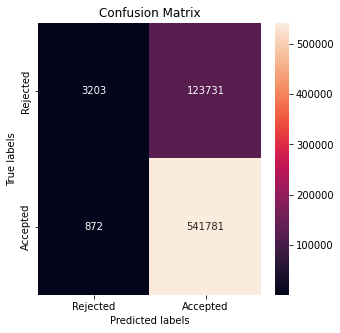

In [50]:
target_classes = ['Rejected', 'Accepted']
print(evaluation_summary("Baseline Model", test["merged_or_not"], y_pred , target_classes))

ROC-AUC curve code taken from [here](https://www.kaggle.com/code/beletecheneke/xgboost-with-roc-curve-notebook-auprc-93) 

In [51]:
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
def roc_auc_curve(test_results, y_pred):
  fpr, tpr, _ = roc_curve(test_results.values, y_pred)
  roc_auc = auc(fpr, tpr)
  #xgb.plot_importance(gbm)
  #plt.show()
  plt.figure(figsize=(5,5))
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([-0.02, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

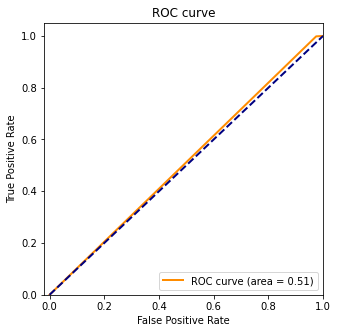

In [52]:
roc_auc_curve(test["merged_or_not"], y_pred)

### **Feature Selection with XGBoost**

Study [this](https://notebook.community/minesh1291/MachineLearning/xgboost/feature_importance_v1) to understand how feature importance is decided in the following graph.

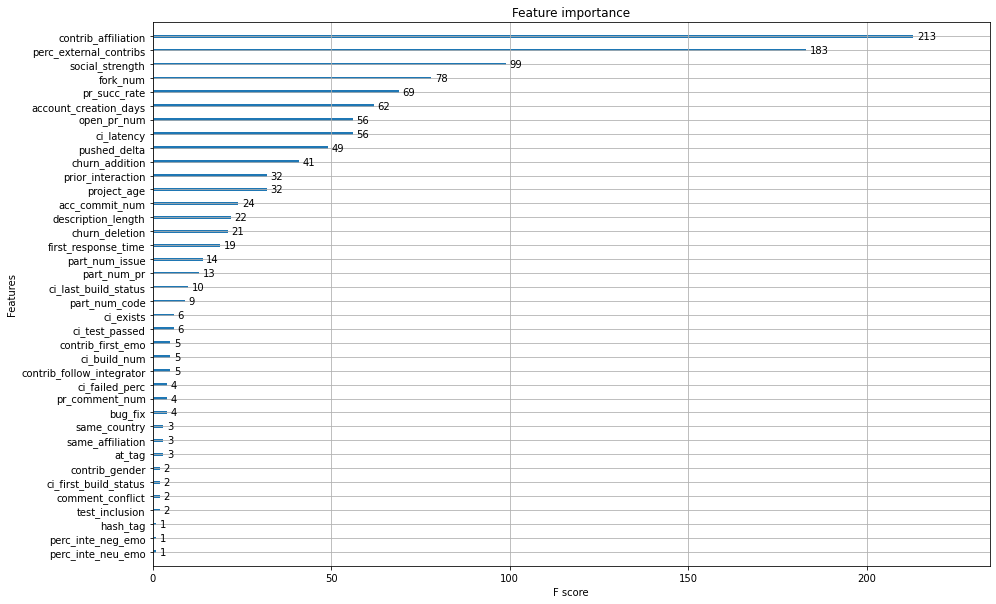

In [53]:
plt.rcParams["figure.figsize"] = (15, 10)
plot_importance(model)
plt.show()

Get rid of features one by one!

In [54]:
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

In [55]:
sorted_idx = np.argsort(model.feature_importances_)[::-1]
print(sorted_idx)
for index in sorted_idx:
  print([X.columns[index], model.feature_importances_[index]])

[20  4 29 17 10 19 33 41 18 16 40 36 14 39 31 26 12 42 22 43  3 27 25 15
  0  2  1  6  7 35  9 28 23 37 13 44 11  8 34  5 32 38 30 24 21]
['ci_last_build_status', 0.19557337]
['part_num_issue', 0.19254452]
['acc_commit_num', 0.075367376]
['ci_test_passed', 0.063339755]
['at_tag', 0.04856083]
['ci_first_build_status', 0.0455661]
['contrib_gender', 0.044170953]
['prior_interaction', 0.03898106]
['ci_failed_perc', 0.036599047]
['ci_build_num', 0.03637234]
['contrib_follow_integrator', 0.027704723]
['contrib_first_emo', 0.022163281]
['ci_exists', 0.019241529]
['perc_inte_neu_emo', 0.018245542]
['account_creation_days', 0.014846819]
['open_pr_num', 0.011731912]
['description_length', 0.011360574]
['social_strength', 0.010078561]
['fork_num', 0.009553689]
['same_country', 0.009459412]
['pr_comment_num', 0.008769179]
['first_response_time', 0.008054419]
['pr_succ_rate', 0.0066718543]
['ci_latency', 0.0054238057]
['perc_external_contribs', 0.004993116]
['churn_deletion', 0.0039834464]
['churn_

Strategy 1: Mean of from the feature importance list for determining threshold.

In [56]:
sum = 0.0
for value in model.feature_importances_:
  sum = sum+value

threshold_1 = sum/len(model.feature_importances_)
print(threshold_1)

0.022222225327924307


In [57]:
imp_features_1 = []
for index in sorted_idx:
  if model.feature_importances_[index]>=threshold_1:
    imp_features_1.append(X.columns[index])

print(imp_features_1)
print(len(imp_features_1))

['ci_last_build_status', 'part_num_issue', 'acc_commit_num', 'ci_test_passed', 'at_tag', 'ci_first_build_status', 'contrib_gender', 'prior_interaction', 'ci_failed_perc', 'ci_build_num', 'contrib_follow_integrator']
11


In [58]:
X_new_1 = pd.DataFrame(columns = imp_features_1)
for feature in imp_features_1:
  X_new_1[feature] = train[feature]

model_new = xgb.XGBClassifier(max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
                          reg_alpha = int(best_hyperparams['reg_alpha']), min_child_weight=int(best_hyperparams['min_child_weight']),
                          colsample_bytree=int(best_hyperparams['colsample_bytree']))

print("Computation Time")
start=datetime.now()

model_new.fit(X_new_1, y)

print(datetime.now()-start)

test_new_1 = pd.DataFrame(columns = imp_features_1)
for feature in imp_features_1:
  test_new_1[feature] = test[feature]

y_pred_new_1 = model_new.predict(test_new_1)

Computation Time
0:00:19.301881


In [59]:
results_new_1 = (test["merged_or_not"] == y_pred_new_1)
accuracy_new_1 = results_new_1.sum() / results_new_1.size
print(accuracy_new_1)

0.8198426791440097


Evaluation for: New Model with better performing features
              precision    recall  f1-score   support

    Rejected      0.642     0.112     0.191    126934
    Accepted      0.826     0.985     0.899    542653

    accuracy                          0.820    669587
   macro avg      0.734     0.549     0.545    669587
weighted avg      0.791     0.820     0.764    669587



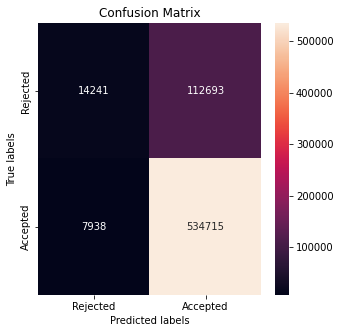

In [60]:
print(evaluation_summary("New Model with better performing features", test["merged_or_not"], y_pred_new_1 , target_classes))

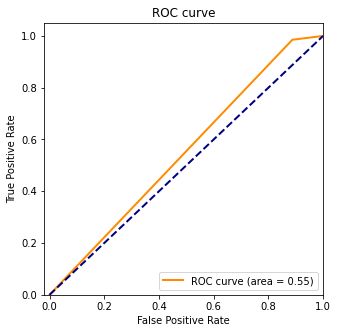

In [61]:
roc_auc_curve(test["merged_or_not"], y_pred_new_1)

Read [this](https://ai.stanford.edu/blog/removing-spuriousfeature/).
[Deciding the threshold for feature importance.](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00472-4)

Strategy 2 : Standard Deviation for determining threshold.

In [ ]:
print(model.feature_importances_)

[0.00422032 0.00310115 0.00389371 0.00718799 0.19710982 0.
 0.00371113 0.00356147 0.00030462 0.00311593 0.04971382 0.00148864
 0.01023681 0.00221402 0.01970145 0.00444882 0.03723435 0.06483499
 0.03746606 0.04664063 0.20020813 0.         0.00829701 0.00235995
 0.         0.0056829  0.01121027 0.00746362 0.00236725 0.07122775
 0.         0.01273865 0.         0.04519746 0.         0.00334202
 0.02268974 0.00240842 0.         0.01867879 0.02835825 0.03648927
 0.0099178  0.00968561 0.00149158]


In [ ]:
threshold_2 = np.std(model.feature_importances_)

imp_features_2 = []
for index in sorted_idx:
  if model.feature_importances_[index]>=threshold_2:
    feature_to_consider_1 = X.columns[index]
    imp_features_2.append(feature_to_consider_1)

print(imp_features_2)
print(len(imp_features_2))

['ci_last_build_status', 'part_num_issue', 'acc_commit_num', 'ci_test_passed', 'at_tag', 'ci_first_build_status', 'contrib_gender']
7


In [ ]:
X_new_2 = pd.DataFrame(columns = imp_features_2)
for feature in imp_features_2:
  X_new_2[feature] = train[feature]

print("Computation Time")
start=datetime.now()

model_new.fit(X_new_2, y)

print(datetime.now()-start)

test_new_2 = pd.DataFrame(columns = imp_features_2)
for feature in imp_features_2:
  test_new_2[feature] = test[feature]

y_pred_new_2 = model_new.predict(test_new_2)

Computation Time
0:00:15.953167


In [ ]:
results_new_2 = (test["merged_or_not"] == y_pred_new_2)
accuracy_new_2 = results_new_2.sum() / results_new_2.size
print(accuracy_new_2)

0.8150576400079452


Evaluation for: New Model with better performing features
              precision    recall  f1-score   support

    Rejected      0.628     0.060     0.109    126934
    Accepted      0.819     0.992     0.897    542653

    accuracy                          0.815    669587
   macro avg      0.723     0.526     0.503    669587
weighted avg      0.782     0.815     0.748    669587



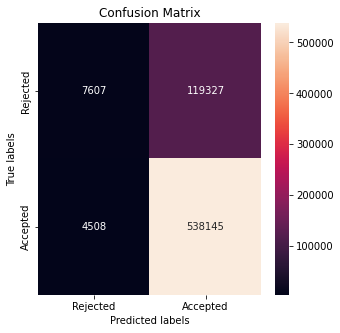

In [ ]:
print(evaluation_summary("New Model with better performing features", test["merged_or_not"], y_pred_new_2 , target_classes))

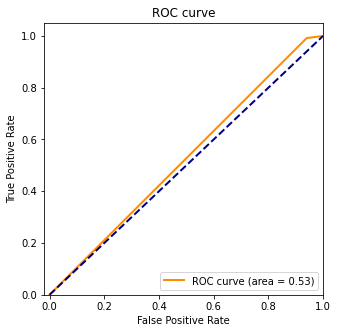

In [ ]:
roc_auc_curve(test["merged_or_not"], y_pred_new_2)

Strategy 3 : Derivatives of feature importance values where dy = the feature importance value itself and dx = the mean of all the feature importance values. Determining the average of the dydx values for threshold.

In [ ]:
from numpy import diff

dx = threshold_1
features_dydx = diff(model.feature_importances_)/dx
print(features_dydx)

sum = 0.0
for value in features_dydx:
  sum = sum+value
threshold_3 = sum/len(features_dydx)
print(threshold_3)

imp_features_3 = []
for index in sorted_idx-1:
  for val in features_dydx:
    if val > threshold_3:
      feature_to_consider_2 = X.columns[index]
  imp_features_3.append(feature_to_consider_2)

print(imp_features_3)
print(len(imp_features_3))

[-5.03628217e-02  3.56652439e-02  1.48242816e-01  8.54648018e+00
 -8.86993980e+00  1.67000756e-01 -6.73467992e-03 -1.46558329e-01
  1.26509249e-01  2.09690428e+00 -2.17013240e+00  3.93667668e-01
 -3.61025423e-01  7.86933899e-01 -6.86368287e-01  1.47534883e+00
  1.24202847e+00 -1.23160136e+00  4.12855595e-01  6.91053581e+00
 -9.00936413e+00  3.73365253e-01 -2.67167747e-01 -1.06197521e-01
  2.55730659e-01  2.48731479e-01 -1.68599516e-01 -2.29336575e-01
  3.09872222e+00 -3.20524812e+00  5.73239267e-01 -5.73239267e-01
  2.03388524e+00 -2.03388524e+00  1.50390938e-01  8.70647073e-01
 -9.12659168e-01 -1.08378805e-01  8.40545416e-01  4.35575753e-01
  3.65895569e-01 -1.19571579e+00 -1.04486272e-02 -3.68731320e-01]
-0.0027907556663690643
['ci_first_build_status', 'pr_comment_num', 'pushed_delta', 'ci_build_num', 'hash_tag', 'ci_failed_perc', 'core_member', 'ci_test_passed', 'ci_latency', 'contrib_follow_integrator', 'perc_inte_neu_emo', 'contrib_affiliation', 'bug_fix', 'perc_inte_pos_emo', 'fi

In [ ]:
X_new_3 = pd.DataFrame(columns = imp_features_3)
for feature in imp_features_3:
  X_new_3[feature] = train[feature]

print("Computation Time")
start=datetime.now()

model_new.fit(X_new_3, y)

print(datetime.now()-start)

test_new_3 = pd.DataFrame(columns = imp_features_3)
for feature in imp_features_3:
  test_new_3[feature] = test[feature]

y_pred_new_3 = model_new.predict(test_new_3)

Computation Time
0:00:41.502482


In [ ]:
results_new_3 = (test["merged_or_not"] == y_pred_new_3)
accuracy_new_3 = results_new_3.sum() / results_new_3.size
print(accuracy_new_3)

0.815099456829359


Evaluation for: New Model with better performing features
              precision    recall  f1-score   support

    Rejected      0.767     0.035     0.068    126934
    Accepted      0.816     0.997     0.897    542653

    accuracy                          0.815    669587
   macro avg      0.792     0.516     0.482    669587
weighted avg      0.806     0.815     0.740    669587



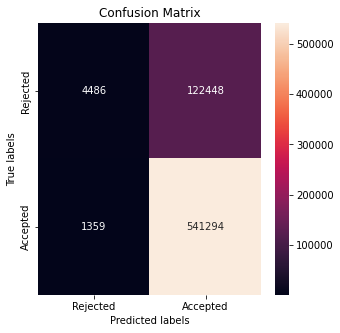

In [ ]:
print(evaluation_summary("New Model with better performing features", test["merged_or_not"], y_pred_new_3 , target_classes))

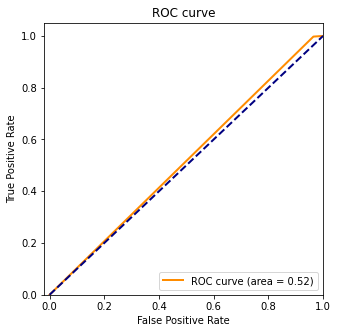

In [ ]:
roc_auc_curve(test["merged_or_not"], y_pred_new_3)

Feature Selection with information gain and entropy.
[Here](https://www.kaggle.com/code/ma7555/decision-trees-information-gain-from-scratch), [here](https://https://www.sciencedirect.com/science/article/pii/S0957417420302001).

Strategy 4 : Information gain and entropy for feature selection.

In [ ]:
'''
import math
from collections import Counter

feature_gain = pd.DataFrame(columns = ["feature", "gain"])

def entropy(labels):
    entropy=0
    label_counts = Counter(labels)
    for label in label_counts:
        prob_of_label = label_counts[label] / len(labels)
        entropy -= prob_of_label * math.log2(prob_of_label)
    return entropy

def information_gain(starting_labels, split_labels):
    info_gain = entropy(starting_labels)
    for branched_subset in split_labels:
        info_gain -= len(branched_subset) * entropy(branched_subset) / len(starting_labels)
    return info_gain

def split(dataset, column):
    split_data = []
    col_vals = dataset[column].unique()
    for col_val in col_vals:
        split_data.append(dataset[dataset[column] == col_val])
    return(split_data)

def find_best_split(dataset):
  global feature_gain 
  feature_gain = pd.DataFrame(columns=['feature', 'gain'])
  best_gain = 0
  best_feature = 0
  features = list(dataset.columns)
  features.remove('merged_or_not')
  for feature in features:
    split_data = split(dataset, feature)
    split_labels = [dataframe['merged_or_not'] for dataframe in split_data]
    gain = information_gain(dataset['merged_or_not'], split_labels)
    new_row = {'feature': feature, 'gain': gain}
    feature_gain = feature_gain.append(new_row, ignore_index = True)
    if gain>best_gain:
      best_gain = gain
      best_feature = feature
  return best_feature, best_gain

new_data = split(train, find_best_split(train)[0])
'''

In [ ]:
'''
feature_gain.head(5)
'''

In [ ]:
'''
feature_gain['top_most']=np.where(feature_gain['gain'].cumsum()<=feature_gain['gain'].sum() * 0.2,0,1)
feature_gain.sort_index(inplace=True)

feature_gain
'''

In [ ]:
'''
sum = 0.0
for rows in feature_gain.itertuples():
  sum = sum+rows.gain

threshold_4 = sum/len(feature_gain)
print(threshold_4)
'''

In [ ]:
'''
imp_features_4 = []
for rows in feature_gain.itertuples():
  if rows.gain>=threshold_4:
    imp_features_4.append(rows.feature)

print(imp_features_4)
print(len(imp_features_4))
'''

In [ ]:
'''
X_new_4 = pd.DataFrame(columns = imp_features_4)
for feature in imp_features_4:
  X_new_4[feature] = train[feature]

print("Computation Time")
start=datetime.now()

model_new.fit(X_new_4, y)

print(datetime.now()-start)

test_new_4 = pd.DataFrame(columns = imp_features_4)
for feature in imp_features_4:
  test_new_4[feature] = test[feature]

y_pred_new_4 = model_new.predict(test_new_4)
'''

In [ ]:
'''
results_new_4 = (test["merged_or_not"] == y_pred_new_4)
accuracy_new_4 = results_new_4.sum() / results_new_4.size
print(accuracy_new_4)
'''

In [ ]:
'''
print(evaluation_summary("New Model with better performing features", test["merged_or_not"], y_pred_new_4, target_classes))
'''

In [ ]:
'''
roc_auc_curve(test["merged_or_not"], y_pred_new_4)
'''

In [ ]:
'''
imp_features_5 = []
for rows in feature_gain.itertuples():
  if rows.top_most == 1:
    imp_features_5.append(rows.feature)

print(imp_features_5)
print(len(imp_features_5))
'''

In [ ]:
'''
X_new_5 = pd.DataFrame(columns = imp_features_5)
for feature in imp_features_5:
  X_new_5[feature] = train[feature]

model_new.fit(X_new_5, y)

test_new_5 = pd.DataFrame(columns = imp_features_5)
for feature in imp_features_5:
  test_new_5[feature] = test[feature]

y_pred_new_5 = model_new.predict(test_new_5)

print("Computation Time")
start=datetime.now()
print(datetime.now()-start)
'''

In [ ]:
#X_new_5

In [ ]:
#y

In [ ]:
'''
results_new_5 = (test_results == y_pred_new_5)
accuracy_new_5 = results_new_5.sum() / results_new_5.size
print(accuracy_new_5)
'''

In [ ]:
'''
print(evaluation_summary("New Model with better performing features", test_results, y_pred_new_5, target_classes))
'''

In [ ]:
#roc_auc_curve(test_results, y_pred_new_5)

Features from strategy 1 (Mean of Feature Importance) will be used to feature selection.

In [62]:
rec = df[int(len(df.index)/2):len(df.index)]

rec

,id,project_id,github_id,pull_request_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,...,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
1673968,1673969,16160044,1198,35541685,projectatomic,atomic,0,143,NaN,2,...,0,2,0,0,19.0,0,0.305247,0,143,0
1673969,1673970,4314311,2007,11518322,keycloak,keycloak,1,55,55.0,1,...,0,0,0,0,9.0,0,0.148940,0,55,0
1673970,1673971,88889162,245,61433613,ministryofjustice,et3,0,1696,NaN,12,...,0,0,0,0,1896.0,0,0.038939,0,1696,0
1673971,1673972,8804952,2436,27958680,SonarSource,sonarqube,1,3640,3640.0,2,...,0,0,0,0,58.0,1,0.150121,0,3640,0
1673972,1673973,26051663,91,9852622,JMRI,JMRI,1,0,0.0,1,...,0,0,0,0,14.0,0,0.002150,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3347932,3347933,30544060,258,25263316,Kronos-Integration,kronos-service-consul,1,9,9.0,1,...,0,0,0,0,2537.0,0,0.696970,0,9,0
3347933,3347934,1142,27876,9812944,saltstack,salt,0,1165,NaN,1,...,0,1,0,0,42.0,0,0.056849,0,1165,0
3347934,3347935,31499094,444,19063491,mjmlio,mjml,1,8834,8834.0,2,...,0,8,0,0,597.0,0,0.002041,0,8834,0
3347935,3347936,55317,651,2087506,zotonic,zotonic,0,703,NaN,7,...,0,0,0,0,10.0,0,0.000732,0,703,0


In [63]:
rec_columns = rec.columns.to_list()

for metric in rec_columns:
  if metric not in list_of_metrics:
    rec.drop(metric, axis=1, inplace=True)

rec

,id,merged_or_not,perc_external_contribs,churn_addition,churn_deletion,pr_comment_num,part_num_issue,part_num_commit,part_num_pr,part_num_code,...,contrib_affiliation,contrib_first_emo,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation
1673968,1673969,0,0.010695,14,0,0,3,0,0,0,...,redhatofficial,neutral,0.0,0.5,0.5,0,193,0.333333,NaN,0.0
1673969,1673970,1,0.190860,6,3,0,0,0,0,0,...,red hat,NaN,0.0,0.0,0.0,0,128,0.210526,1.0,1.0
1673970,1673971,0,0.083893,32,33,0,0,0,0,0,...,NaN,NaN,0.0,0.0,0.0,0,41,0.222222,NaN,NaN
1673971,1673972,1,0.000404,13,13,0,0,0,0,0,...,sonarsource,NaN,0.0,0.0,0.0,0,847,0.314286,1.0,1.0
1673972,1673973,1,0.082583,6,3,0,0,0,0,0,...,NaN,NaN,0.0,0.0,0.0,0,61,0.170732,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3347932,3347933,1,0.000000,0,0,0,0,0,0,0,...,NaN,NaN,0.0,0.0,0.0,0,30,0.000000,NaN,NaN
3347933,3347934,0,0.277100,9,1,0,2,0,0,0,...,NaN,neutral,0.0,0.0,0.0,0,865,0.268293,1.0,NaN
3347934,3347935,1,0.109677,6,0,0,2,0,0,0,...,NaN,neutral,0.0,0.0,0.0,0,2,0.083333,1.0,NaN
3347935,3347936,0,0.154545,3,12,0,0,0,0,0,...,NaN,NaN,0.0,0.0,0.0,0,13,0.157895,NaN,NaN


Manually annotating the metrics 'ci_first_build_status', 'ci_last_build_status', 'language', 'contrib_gender', 'contrib_country', 'contrib_affiliation' and 'contrib_first_emo' using the [dictionaries](https://colab.research.google.com/drive/1_68KgoyDN1w6K4nzdfPjaI-aoJOLTDy7#scrollTo=gWAEafmevNHF&line=1&uniqifier=1) created earlier. It is possible that one or many keys vary from the training dataset to the testing dataset. However, at this point, it would be cumbersome to manually check. Hence, it is necessary to check if the test fails and if so, assign new labels to those unique values.

In [77]:
for metric in object_metrics:
  if metric == 'ci_first_build_status':
    for key in dict_ci_first_build_status:
      value = dict_ci_first_build_status[key]
      rec[metric].replace(value, key, inplace= True)
  if metric == 'ci_last_build_status':
    for key in dict_ci_last_build_status:
      value = dict_ci_last_build_status[key]
      rec[metric].replace(value, key, inplace= True)
  if metric == 'language':
    for key in dict_language:
      value = dict_language[key]
      rec[metric].replace(value, key, inplace= True)
  if metric == 'contrib_gender':
    for key in dict_contrib_gender:
      value = dict_contrib_gender[key]
      rec[metric].replace(value, key, inplace= True)
  if metric == 'contrib_country':
    for key in dict_contrib_country:
      value = dict_contrib_country[key]
      rec[metric].replace(value, key, inplace= True)
  if metric == 'contrib_affiliation':
    for key in dict_contrib_affiliation:
      value = dict_contrib_affiliation[key]
      rec[metric].replace(value, key, inplace= True)
  if metric == 'contrib_first_emo':
    for key in dict_contrib_first_emo:
      value = dict_contrib_first_emo[key]
      rec[metric].replace(value, key, inplace= True)

In [78]:
rec['contrib_gender']

1673968    1
1673969    1
1673970    1
1673971    1
1673972    1
          ..
3347932    1
3347933    1
3347934    1
3347935    2
3347936    1
Name: contrib_gender, Length: 1673969, dtype: int64

Adding the column of 'id' as it would be useful later.

In [79]:
#imp_features_1.insert(0, 'id')
rec_test = pd.DataFrame(columns = imp_features_1)

for feature in imp_features_1:
  rec_test[feature] = rec[feature]

rec_test

,ci_last_build_status,part_num_issue,acc_commit_num,ci_test_passed,at_tag,ci_first_build_status,contrib_gender,prior_interaction,ci_failed_perc,ci_build_num,contrib_follow_integrator
1673968,2.0,3,797,NaN,0,2.0,1,193,NaN,NaN,0
1673969,1.0,0,843,1.0,0,1.0,1,128,0.0,1.0,0
1673970,2.0,0,69,NaN,0,2.0,1,41,NaN,NaN,0
1673971,1.0,0,6150,1.0,0,1.0,1,847,0.0,1.0,0
1673972,2.0,0,58,NaN,0,2.0,1,61,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
3347932,2.0,0,414,NaN,0,2.0,1,30,NaN,NaN,0
3347933,2.0,2,3389,NaN,1,2.0,1,865,NaN,NaN,0
3347934,2.0,2,2,NaN,1,2.0,1,2,NaN,NaN,0
3347935,2.0,0,3,NaN,0,2.0,2,13,NaN,NaN,0


Some columns still have NaN values, i.e., not int or float type labels which is needed for testing. It is important to manually annotate them and keep the record.

In [100]:
new_labels = ['ci_test_passed', 'ci_failed_perc', 'ci_build_num']

for label in new_labels:
  globals()['dict_%s' % label] = pd.Series(rec_test[label].unique()).to_dict()

In [102]:
for labels in new_labels:
  if labels == 'ci_test_passed':
    for key in dict_ci_test_passed:
      value = dict_ci_test_passed[key]
      rec_test[labels].replace(value, key, inplace= True)
  if labels == 'ci_failed_perc':
    for key in dict_ci_failed_perc:
      value = dict_ci_failed_perc[key]
      rec_test[labels].replace(value, key, inplace= True)
  if labels == 'ci_build_num':
    for key in dict_ci_build_num:
      value = dict_ci_build_num[key]
      rec_test[labels].replace(value, key, inplace= True)

In [104]:
rec_test

,ci_last_build_status,part_num_issue,acc_commit_num,ci_test_passed,at_tag,ci_first_build_status,contrib_gender,prior_interaction,ci_failed_perc,ci_build_num,contrib_follow_integrator
1673968,2.0,3,797,2.0,0,2.0,1,193,9.0,0.0,0
1673969,1.0,0,843,1.0,0,1.0,1,128,9.0,1.0,0
1673970,2.0,0,69,2.0,0,2.0,1,41,9.0,0.0,0
1673971,1.0,0,6150,1.0,0,1.0,1,847,9.0,1.0,0
1673972,2.0,0,58,2.0,0,2.0,1,61,9.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
3347932,2.0,0,414,2.0,0,2.0,1,30,9.0,0.0,0
3347933,2.0,2,3389,2.0,1,2.0,1,865,9.0,0.0,0
3347934,2.0,2,2,2.0,1,2.0,1,2,9.0,0.0,0
3347935,2.0,0,3,2.0,0,2.0,2,13,9.0,0.0,0


In [105]:
rec_y_pred = model_new.predict(rec_test)

In [106]:
results_new_rec = (rec['merged_or_not'] == rec_y_pred)
accuracy_new_rec = results_new_rec.sum() / results_new_rec.size
print(accuracy_new_rec)

0.819356272427984


Evaluation for: Model Perfomance on Test Data
              precision    recall  f1-score   support

    Rejected      0.636     0.123     0.207    319295
    Accepted      0.826     0.983     0.898   1354674

    accuracy                          0.819   1673969
   macro avg      0.731     0.553     0.552   1673969
weighted avg      0.790     0.819     0.766   1673969



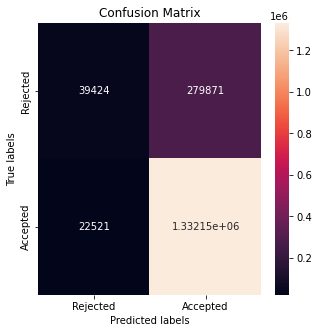

In [107]:
print(evaluation_summary("Model Perfomance on Test Data", rec["merged_or_not"], rec_y_pred, target_classes))

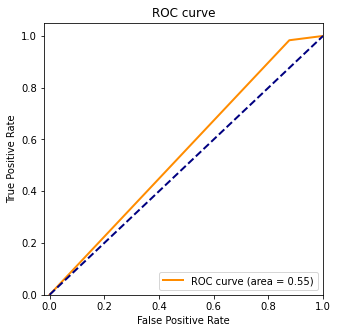

In [108]:
roc_auc_curve(rec['merged_or_not'], rec_y_pred)

# **SHAP**

Using SHAP to determine the underperforming features among the lot.

In [109]:
!pip3 install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.6 MB/s 


In [110]:
import shap

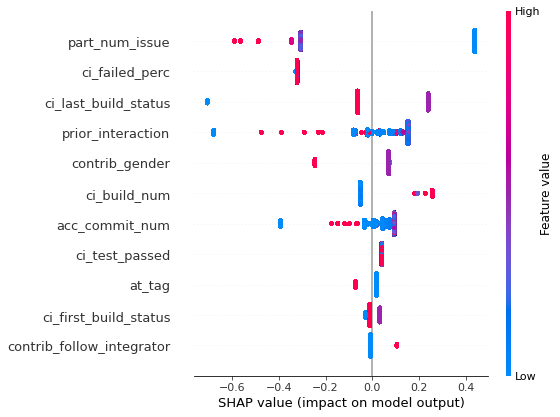

In [111]:
explainer = shap.TreeExplainer(model_new)
shap_values = explainer.shap_values(rec_test)

shap.initjs()
shap.summary_plot(shap_values, rec_test)

Understanding the Shapley Value [here](https://christophm.github.io/interpretable-ml-book/shapley.html). [More](https://arxiv.org/pdf/2102.10936.pdf) things about Shapley.

Interpreting the SHAP plot:
1. The y-axis indicates importance of the metrics with the top-most one being the most important one and the bottom one being the least important metric.
2. The x-axis is the SHAP values, indiacting the change in log-odds.
3. Gradient color indicates the original value for that variable. 
4. Each point represents the row from the original dataset.

[Reference] [link text](https://blog.datascienceheroes.com/how-to-interpret-shap-values-in-r/)

1. Check [this](https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/) out.
2. Check [this](https://www.kaggle.com/general/237792) out.
3. Check [this](https://www.kaggle.com/code/prashant111/xgboost-k-fold-cv-feature-importance/notebook) out for more XGBoost information.

Check [this](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) out for parameter tuning.

Click [here](https://www.kaggle.com/code/bryanb/xgboost-explainability-with-shap/notebook), [here](https://gmd.copernicus.org/preprints/gmd-2020-59/gmd-2020-59.pdf), [here](https://stackoverflow.com/questions/69937376/explaination-of-shap-value-from-xgboost) for more SHAP related documents.

For BEAM, look at actionable features and come up with why you can recommend something before the recommendation.

# **BEAM**
Study [this](https://www.width.ai/post/what-is-beam-search)

In [ ]:
rec_test = pd.concat([rec['id'], rec_test], axis = 1)

In [ ]:
pull_request_characteristics = ['churn_addition', 'bug_fix', 'test_inclusion',
                                'at_tag', 'part_num_X', 'ci_exists', 'ci_latency',
                                'ci_test_passed', 'ci_failed_perc', 'churn_deletion',
                                'description_length', 'comment_conflict', 'pr_comment_num',
                                'part_num_code', 'ci_build_num', 'perc_neg_emotion',
                                'perc_pos_emotion', 'perc_neu_emotion', 'ci_first_build_status',
                                'ci_last_build_status']

for feature in imp_features_2:
  if feature in pull_request_characteristics:
    print(feature," can be used for recommendation.")